In [10]:
# ==============================
# 📦 STEP 1: Installation
# ==============================
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install nltk pandas numpy matplotlib scikit-learn tensorflow transformers sentencepiece


  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-zibfaljw
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-zibfaljw
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


In [11]:
# ==============================
# 📚 STEP 2: Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Concatenate, Dropout
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from normalizer import normalize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# ==============================
# 📄 STEP 3: Load & Split Dataset
# ==============================
data = pd.read_csv("/content/Copy of Bangla_news (1).csv")
data = data.dropna(subset=['content', 'title'])
data = data[data['content'].str.strip() != '']
data = data[data['title'].str.strip() != '']

train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [13]:
# ==============================
# 🧼 STEP 4: Normalize (BUET)
# ==============================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\u0980-\u09FFa-zA-Z0-9\s]", "", text)
    return normalize(text)

for df in [train_data, val_data, test_data]:
    df['content'] = df['content'].astype(str).apply(clean_text)
    df['title'] = df['title'].astype(str).apply(clean_text)

In [14]:
# ==============================
# 🔢 STEP 5: Tokenization & Padding
# ==============================
content_tok = Tokenizer()
content_tok.fit_on_texts(train_data['content'])
title_tok = Tokenizer()
title_tok.fit_on_texts(train_data['title'])

max_content_len = 150
max_title_len = 20

# Prepare data
X_train = pad_sequences(content_tok.texts_to_sequences(train_data['content']), maxlen=max_content_len, padding='post')
X_val = pad_sequences(content_tok.texts_to_sequences(val_data['content']), maxlen=max_content_len, padding='post')
X_test = pad_sequences(content_tok.texts_to_sequences(test_data['content']), maxlen=max_content_len, padding='post')

title_seq_train = title_tok.texts_to_sequences(train_data['title'])
title_seq_val = title_tok.texts_to_sequences(val_data['title'])
title_seq_test = title_tok.texts_to_sequences(test_data['title'])

decoder_input_train = pad_sequences([seq[:-1] for seq in title_seq_train], maxlen=max_title_len-1, padding='post')
decoder_input_val = pad_sequences([seq[:-1] for seq in title_seq_val], maxlen=max_title_len-1, padding='post')

decoder_target_train = pad_sequences([seq[1:] for seq in title_seq_train], maxlen=max_title_len-1, padding='post')
decoder_target_val = pad_sequences([seq[1:] for seq in title_seq_val], maxlen=max_title_len-1, padding='post')

vocab_content = len(content_tok.word_index) + 1
vocab_title = len(title_tok.word_index) + 1
embedding_dim = 256
units = 256

In [15]:
# ==============================
# 🧠 STEP 6: Build Seq2Seq Models
# ==============================
def build_seq2seq(model_type='lstm'):
    encoder_inputs = Input(shape=(max_content_len,))
    enc_emb = Embedding(vocab_content, embedding_dim)(encoder_inputs)

    decoder_inputs = Input(shape=(max_title_len - 1,))
    dec_emb = Embedding(vocab_title, embedding_dim)(decoder_inputs)

    if model_type == 'lstm':
        encoder_layer = LSTM(units, return_state=True)
        encoder_outputs, state_h, state_c = encoder_layer(enc_emb)
        encoder_states = [state_h, state_c]
        decoder_layer = LSTM(units, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_layer(dec_emb, initial_state=encoder_states)

    elif model_type == 'bilstm':
        encoder_layer = Bidirectional(LSTM(units, return_state=True), merge_mode='concat')
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_layer(enc_emb)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]
        decoder_layer = LSTM(units * 2, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_layer(dec_emb, initial_state=encoder_states)

    decoder_dense = Dense(vocab_title, activation='softmax')(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_seq2seq('lstm')
bilstm_model = build_seq2seq('bilstm')

In [16]:
lstm_history = lstm_model.fit([X_train, decoder_input_train], decoder_target_train,
                              validation_data=([X_val, decoder_input_val], decoder_target_val),
                              epochs=20, batch_size=64)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.6494 - loss: 4.8210 - val_accuracy: 0.7199 - val_loss: 2.3471
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.6770 - loss: 2.7476 - val_accuracy: 0.7209 - val_loss: 2.3162
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.6761 - loss: 2.7061 - val_accuracy: 0.7216 - val_loss: 2.3020
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.6793 - loss: 2.6436 - val_accuracy: 0.7223 - val_loss: 2.2902
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6789 - loss: 2.6057 - val_accuracy: 0.7234 - val_loss: 2.2811
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6809 - loss: 2.5355 - val_accuracy: 0.7233 - val_loss: 2.2741
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6832 - loss: 2.4661 - val_accuracy: 0.7257 - val_loss: 2.2639
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6851 - loss: 2.3929 - 

In [17]:
bilstm_history = bilstm_model.fit([X_train, decoder_input_train], decoder_target_train,
                                  validation_data=([X_val, decoder_input_val], decoder_target_val),
                                  epochs=20, batch_size=64)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.6513 - loss: 4.1378 - val_accuracy: 0.7212 - val_loss: 2.3299
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.6780 - loss: 2.7208 - val_accuracy: 0.7219 - val_loss: 2.2957
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.6810 - loss: 2.6423 - val_accuracy: 0.7239 - val_loss: 2.2704
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6831 - loss: 2.5483 - val_accuracy: 0.7273 - val_loss: 2.2010
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.6861 - loss: 2.3871 - val_accuracy: 0.7288 - val_loss: 2.1598
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.6927 - loss: 2.2058 - val_accuracy: 0.7305 - val_loss: 2.1423
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.6974 - loss: 2.0443 - val_accuracy: 0.7320 - val_loss: 2.1419
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.7032 - loss: 1

In [19]:
# ==============================
# 🔄 STEP 7: Transformer
# ==============================
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add
import tensorflow as tf
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

enc_inputs = Input(shape=(max_content_len,))
enc_emb = Embedding(vocab_content, embedding_dim)(enc_inputs)
enc_out = TransformerBlock(embedding_dim, 4, 512)(enc_emb)

dec_inputs = Input(shape=(max_title_len - 1,))
dec_emb = Embedding(vocab_title, embedding_dim)(dec_inputs)
dec_attn = MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(dec_emb, enc_out)
dec_out = LayerNormalization(epsilon=1e-6)(dec_emb + dec_attn)
dec_ffn = Dense(embedding_dim, activation='relu')(dec_out)
dec_out = LayerNormalization(epsilon=1e-6)(dec_out + dec_ffn)

final_out = Dense(vocab_title, activation='softmax')(dec_out)
transformer_model = Model([enc_inputs, dec_inputs], final_out)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
transformer_history = transformer_model.fit([X_train, decoder_input_train], decoder_target_train,
                                            validation_data=([X_val, decoder_input_val], decoder_target_val),
                                            epochs=10 , batch_size=64)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6459 - loss: 4.6307 - val_accuracy: 0.7188 - val_loss: 2.3727
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.6746 - loss: 2.8087 - val_accuracy: 0.7203 - val_loss: 2.3639
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.6778 - loss: 2.7174 - val_accuracy: 0.7309 - val_loss: 2.2468
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.7043 - loss: 2.3508 - val_accuracy: 0.7554 - val_loss: 2.0294
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.7724 - loss: 1.5795 - val_accuracy: 0.7550 - val_loss: 2.0366
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.7727 - loss: 1.1345 - val_accuracy: 0.7513 - val_loss: 2.1025
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7685 - loss: 0.9910 - val_accuracy: 0.7525 - val_loss: 2.1459
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.7714 - loss: 0.9243 -

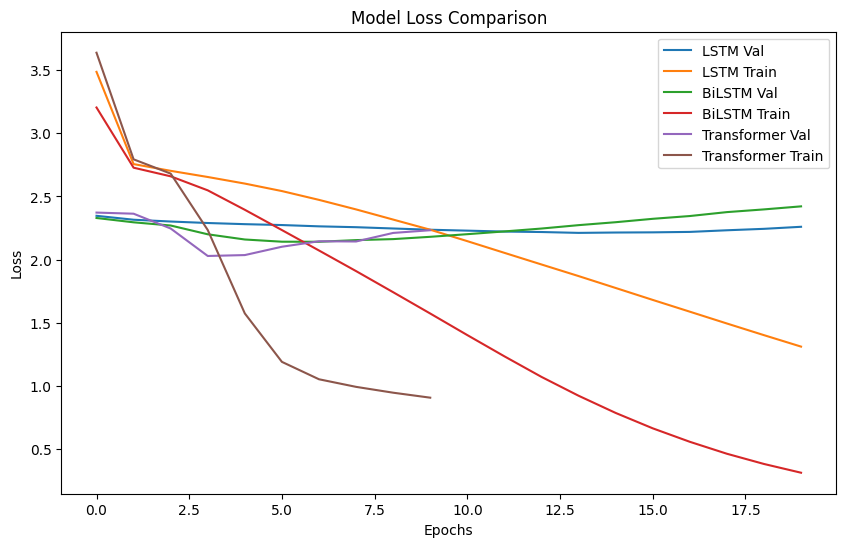

In [21]:
# ==============================
# 📊 STEP 8: Evaluation & Visualization
# ==============================
def plot_history(histories, model_names):
    plt.figure(figsize=(10,6))
    for h, name in zip(histories, model_names):
        plt.plot(h.history['val_loss'], label=f'{name} Val')
        plt.plot(h.history['loss'], label=f'{name} Train')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss Comparison')
    plt.legend()
    plt.show()

plot_history([lstm_history, bilstm_history, transformer_history], ['LSTM', 'BiLSTM', 'Transformer'])


In [23]:
!pip install rouge_score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0e399dd5fcb4ec669ec72beef1c7f3d86570a91e470a063087e3dbc0c540840b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [24]:
# ==============================
# 📏 STEP 9: ROUGE Evaluation
# ==============================
def decode_predictions(model, X, decoder_input):
    preds = model.predict([X, decoder_input])
    preds_seq = np.argmax(preds, axis=-1)
    return title_tok.sequences_to_texts(preds_seq)

def rouge_evaluation(model, name):
    references = title_tok.sequences_to_texts([seq[1:] for seq in decoder_target_val])
    predictions = decode_predictions(model, X_val, decoder_input_val)
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []
    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    print(f"\n{name} ROUGE Scores:")
    print(f"ROUGE-1: {np.mean(rouge1_scores):.4f}")
    print(f"ROUGE-2: {np.mean(rouge2_scores):.4f}")
    print(f"ROUGE-L: {np.mean(rougeL_scores):.4f}")

# Run ROUGE Evaluation
rouge_evaluation(lstm_model, "LSTM")
rouge_evaluation(bilstm_model, "BiLSTM")
rouge_evaluation(transformer_model, "Transformer")


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step

LSTM ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

BiLSTM ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step

Transformer ROUGE Scores:
ROUGE-1: 0.0000
ROUGE-2: 0.0000
ROUGE-L: 0.0000


In [26]:
sample_idx = 10

# Prepare sample
article_seq = X_val[sample_idx:sample_idx+1]
decoder_seq = decoder_input_val[sample_idx:sample_idx+1]
target_seq = decoder_target_val[sample_idx]

# Decode predictions
lstm_pred_text = decode_predictions(lstm_model, article_seq, decoder_seq)[0]
bilstm_pred_text = decode_predictions(bilstm_model, article_seq, decoder_seq)[0]
transformer_pred_text = decode_predictions(transformer_model, article_seq, decoder_seq)[0]

# Ground truth (reference headline)
true_text = title_tok.sequences_to_texts([target_seq])[0]
# Input content
input_text = content_tok.sequences_to_texts(article_seq)[0]

# Show all
print(f"📄 Input Article:\n{input_text}\n")
print(f"✅ Ground Truth Headline:\n{true_text}\n")
print(f"🔷 LSTM Prediction:\n{lstm_pred_text}\n")
print(f"🔶 BiLSTM Prediction:\n{bilstm_pred_text}\n")
print(f"🟪 Transformer Prediction:\n{transformer_pred_text}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
📄 Input Article:
সালে ১৩ এপ্রিল ডুবে যায় বিলাসবহুল জাহাজ টাইটানিক এরপর ১৯৯৭ সালে হলিউড নির্মাতা জেমস ক্যামেরন নির্মাণ করেন টাইটানিক সিনেমায় প্রধান চরিত্রে অভিনয় করেছিলেন কেট উইন্সলেট ও লিওনার্দো ডিক্যাপ্রিও টাইটানিক সিনেমায় কেট একটি গোলাপি রঙের পরেছিলেন এবার যুক্তরাষ্ট্রের নিউ জার্সির একটি নিলাম প্রতিষ্ঠান সেই নিলামে তুলেছে

✅ Ground Truth Headline:
উঠলো টাইটানিকে কেট উইন্সলেটের পরা

🔷 LSTM Prediction:
উঠছে কার্পেটে অ্যাওয়ার্ডস চ্যানের জন্মদিন

🔶 BiLSTM Prediction:
উঠছে টম বোসের ফিউরিয়াস জন্মদিন

🟪 Transformer Prediction:
উঠছে ইন্দোনেশিয়ার রোজকে মিডলটনের জন্মদিন

